In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import csv
import pandas as pd
import numpy as np
from scipy import fftpack
from math import floor, log, log2, log10

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# データ ファイルのパス
PATH = ['Q4149CF2.csv', 'Q416EED018.csv', 'Q4169D2004.csv']

In [3]:
# オリジナルの加速度を読み込む。
def read_data(path):
    data = pd.read_csv(path, skiprows=6)
    data = data.rename(columns={' NS': 'NS'})
    print(data.head())
    data.shape
    return data

# オリジナルの加速度の波形を描画する。
def plot_original_acceleration(df):
    fig, (ax_NS, ax_EW, ax_UD) = plt.subplots(ncols=3, figsize=(10,4))
    ax_NS.plot(df['NS'])
    ax_NS.set_title('NS')
    ax_EW.plot(df['EW'])
    ax_EW.set_title('EW')
    ax_UD.plot(df['UD'])
    ax_UD.set_title('UD')

In [4]:
# 1. データをフーリエ変換する。

def calc_fft_df(df):
    fft_NS = pd.Series(fftpack.fft(df['NS']))
    fft_EW = pd.Series(fftpack.fft(df['EW']))
    fft_UD = pd.Series(fftpack.fft(df['UD']))
    print(f"NS: {fft_NS.size}, EW: {fft_EW.size}, UD: {fft_UD.size}")
    return fft_NS, fft_EW, fft_UD

def calc_scale(fft_series):
    # 周波数スケールの計算
    time_step = 1/100
    freq_list = abs(fftpack.fftfreq(fft_series.size, d=time_step))
    pd.Series(freq_list)[:10]
    return freq_list

In [5]:
# オリジナルのスペクトル波形を表示する

def plot_original_spectral(fft_tuple, freq_list):
    fig, (ax_NS, ax_EW, ax_UD) = plt.subplots(ncols=3, figsize=(10,4))
    fft_df = pd.concat([freq_list * fft_tuple[0], freq_list * fft_tuple[1], freq_list * fft_tuple[2]], axis=1)
    fft_df = fft_df.rename(columns={0: 'NS', 1: 'EW', 2: 'UD'})

    ax_NS.plot(fft_df['NS'])
    ax_NS.set_title('NS')

    ax_EW.plot(fft_df['EW'])
    ax_EW.set_title('EW')

    ax_UD.plot(fft_df['UD'])
    ax_UD.set_title('UD')

In [6]:
# 2. フィルターをかける。(図3を参照)

# フィルターを準備
def filter_1(f):
    """周期の効果を表すフィルターです。
    """
    res = np.sqrt(1 / f[1:])
    return np.concatenate(([0]  ,res))


def filter_high(f):
    """ハイカットフィルターです。
    """
    y = f * 0.1
    result = (1 + 0.694 * (y ** 2) + 0.0557 * (y ** 6) + 0.009664 * (y ** 8)
              + 0.00134 *( y ** 10) + 0.000155 * (y ** 12))
    return 1 / np.sqrt(result)


def filter_low(f):
    """ローカットフィルターです。
    """
    return np.sqrt(1 - np.exp(- (f / 0.5) ** 3))


def create_compound_filter(freq_list):
    filtered_freq = filter_low(freq_list) * filter_high(freq_list) * filter_1(freq_list)
    return filtered_freq

In [7]:
# フィルターをかける。

def apply_filter(fft_tuple, filtered_freq):
    spec_NS = fft_tuple[0] * filtered_freq
    spec_EW = fft_tuple[1] * filtered_freq
    spec_UD = fft_tuple[2] * filtered_freq
    return spec_NS, spec_EW, spec_UD

In [8]:
# 3. 逆フーリエ変換する。

# 逆フーリエ変換する
def calc_ifft_df(data_tuple):
    resyn_NS = pd.Series(np.real(fftpack.ifft(data_tuple[0])))
    resyn_EW = pd.Series(np.real(fftpack.ifft(data_tuple[1])))
    resyn_UD = pd.Series(np.real(fftpack.ifft(data_tuple[2])))

    # 逆フーリエ変換すると、虚部が残る可能性があるので、np.real をかぶせる。
    ifft_df = pd.concat([resyn_NS, resyn_EW, resyn_UD], axis=1)
    ifft_df = ifft_df.rename(columns={0: 'NS', 1: 'EW', 2: 'UD'})
    return ifft_df

In [9]:
# フィルター補正後の加速度波形を表示する
def plot_modified_data(ifft_df):
    fig, (ax_NS, ax_EW, ax_UD) = plt.subplots(ncols=3, figsize=(10,4))

    ax_NS.plot(ifft_df['NS'])
    ax_NS.set_title('NS')

    ax_EW.plot(ifft_df['EW'])
    ax_EW.set_title('EW')

    ax_UD.plot(ifft_df['UD'])
    ax_UD.set_title('UD')

In [10]:
# 4. フィルター処理済みの3成分波形をベクトル的に合成する。
def synthesize_df_vector(df):
    res = []
    for row in df.iterrows():
        a = np.sqrt(row[1]['NS'] ** 2 +  row[1]['EW'] ** 2 +  row[1]['UD'] ** 2)
        res.append(a)
    return pd.Series(res)

# ベクトル合成の結果を表示する
def plot_synthesized_vector(vector):
    synthesized_series = pd.Series(vector)
    plt.figure()
    plt.plot(synthesized_series)

In [11]:
# 5. a を求める。 
def get_a(syn_data):
    """ベクトル波形(フィルター処理済みの3成分波形をベクトル的に合成したもの)の絶対値がある値 a 以上となる時間の合計を計算したとき、
    これがちょうど 0.3秒となるような a を求めて、その a の値を返します。
    
    具体的には、デジタル記録のサンプリング時間間隔 dt としたとき、 
    ベクトル波形 p を絶対値の大きい順に並べて、 0.3 / dt 番目の値を
    a とする。
    
    サンプリング レートは 100Hz なのでサンプリング間隔は 0.01 sec.
    :param syn_data: 合成済みのデータ
    :type syn_data: pandas.Series
    :return: 条件を満たす a の値
    :rypte: float
    """
    dt = 1 / 100
    max_time = int(0.3 / dt)
    
    sorted_series = syn_data.sort_values(ascending=False).reset_index(drop=True)
    # sorted_series.plot(use_index=False)
    return sorted_series[max_time]


In [14]:
def calc_intensity(path):
    # データを読み込みオリジナルの加速度波形を表示します
    df = read_data(path)
    plot_original_acceleration(df)
    
    # フーリエ変換してその結果を表示します
    fft_NS, fft_EW, fft_UD = calc_fft_df(df)
    fft_tuple = (fft_NS, fft_EW, fft_UD)
    # 周波数スケールを計算
    scale = calc_scale(fft_NS)
    plot_original_spectral(fft_tuple, scale)
    
    # フィルターをかけます
    filtered_scale = create_compound_filter(scale)
    filtered_data_tuple = apply_filter(fft_tuple, filtered_scale)
    
    # 逆フーリエ変換しその結果を表示します
    ifft_df = calc_ifft_df(filtered_data_tuple)
    plot_modified_data(ifft_df)
    
    # 計測震度を計算します
    synthesized_vector = synthesize_df_vector(ifft_df)
    plot_synthesized_vector(synthesized_vector)
    # a を計算します
    a = get_a(synthesized_vector)
    print(f"a: {a}")
    # I を計算します
    # 6. Iの小数第３位を四捨五入し、小数第２位を切り捨てたものを計測震度として返す。
    a_real = np.real(a)
    res = round((2 * log10(a) + 0.94), 2)
    print(f"I: {res}")
    return res
    

    NS     EW     UD
0  0.0  0.001 -0.002
1  0.0  0.001 -0.000
2  0.0 -0.000 -0.000
3  0.0 -0.003 -0.001
4  0.0 -0.004 -0.002
NS: 30000, EW: 30000, UD: 30000


/Users/yoshimutamasayuki/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


a: 251.50770710750896
I: 5.74
Q4149CF2.csv: I = 5.74


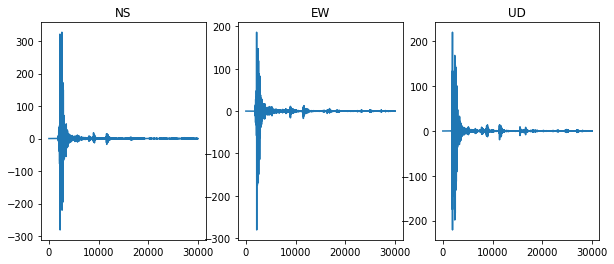

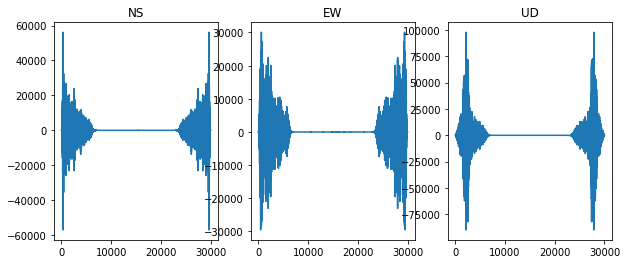

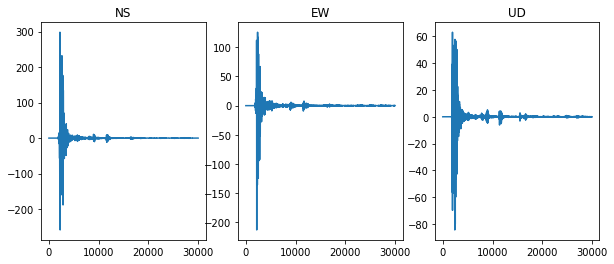

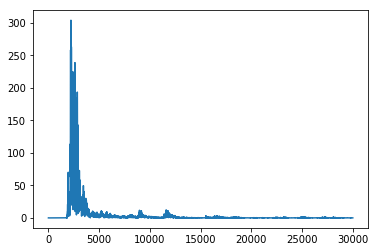

In [17]:
i = calc_intensity(PATH[0])
print(f"{PATH[0]}: I = {i}")

      NS     EW     UD
0 -0.059 -0.144 -0.002
1 -0.011 -0.080  0.034
2  0.054  0.004  0.056
3  0.109  0.096  0.045
4  0.125  0.171  0.011
NS: 24000, EW: 24000, UD: 24000


/Users/yoshimutamasayuki/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


a: 106.44016064915517
I: 4.99
Q416EED018.csv: I = 4.99


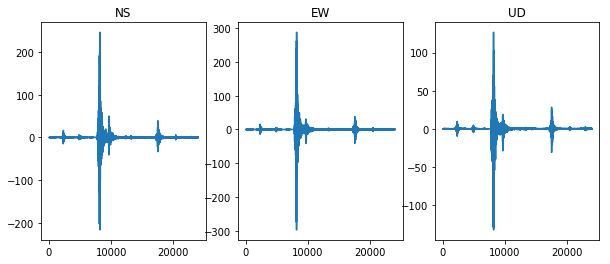

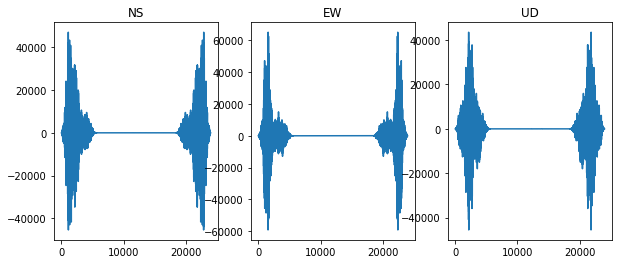

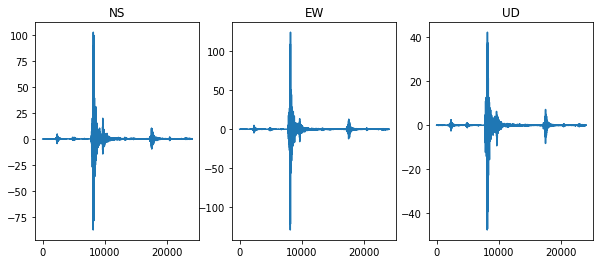

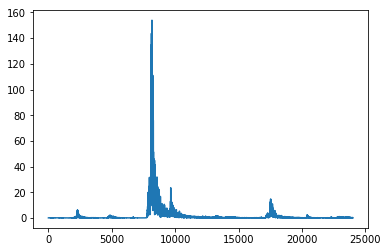

In [19]:
i = calc_intensity(PATH[1])
print(f"{PATH[1]}: I = {i}")

      NS     EW     UD
0  0.015 -0.023 -0.011
1 -0.012 -0.010 -0.021
2 -0.052 -0.008 -0.032
3 -0.087 -0.017 -0.036
4 -0.103 -0.035 -0.021
NS: 30000, EW: 30000, UD: 30000


/Users/yoshimutamasayuki/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


a: 72.13633933469916
I: 4.66
Q4169D2004.csv: I = 4.66


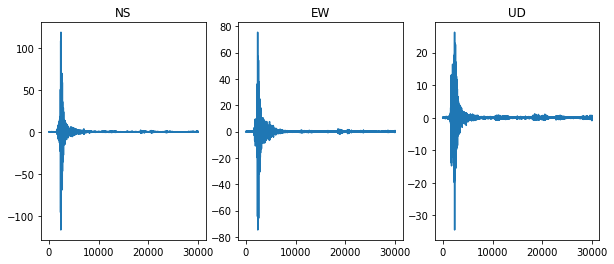

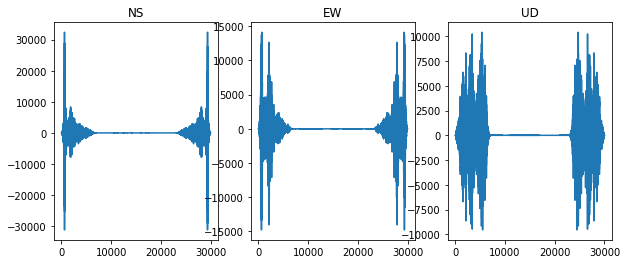

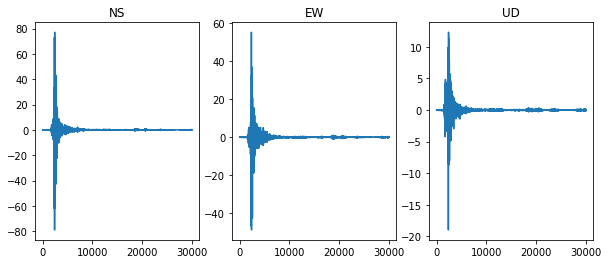

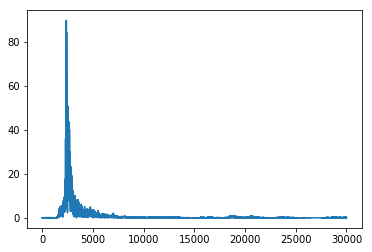

In [20]:
i = calc_intensity(PATH[2])
print(f"{PATH[2]}: I = {i}")